In [1]:
import pandas as pd
import numpy as np
import sklearn
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
columns=['ID','cycles','setting_1','setting_2','setting_3','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

In [3]:
train_data = pd.read_csv("./datasets/train_FD001.txt", sep= "\s+", header = None,names=columns )
#columns = ['ID','cycles','T24','T30','T50','P30','Nf',
          # 'Nc','Ps30','phi','NRf','NRc','BPR','htBleed','W31','W32' ]
#df = train_data[columns]

In [4]:
def add_rul(g):
    g['RUL'] = max(g['cycles']) - g['cycles']
    return g

train = train_data.groupby('ID').apply(add_rul)

C:\Users\HP\AppData\Local\Temp\ipykernel_15432\2964530346.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = train_data.groupby('ID').apply(add_rul)


In [5]:
train.head()

ID  cycles  setting_1  setting_2  setting_3      T2     T24      T30  \
ID                                                                           
1  0   1       1    -0.0007    -0.0004      100.0  518.67  641.82  1589.70   
   1   1       2     0.0019    -0.0003      100.0  518.67  642.15  1591.82   
   2   1       3    -0.0043     0.0003      100.0  518.67  642.35  1587.99   
   3   1       4     0.0007     0.0000      100.0  518.67  642.35  1582.79   
   4   1       5    -0.0019    -0.0002      100.0  518.67  642.37  1582.85   

          T50     P2  ...      NRf      NRc     BPR  farB  htBleed  Nf_dmd  \
ID                    ...                                                    
1  0  1400.60  14.62  ...  2388.02  8138.62  8.4195  0.03      392    2388   
   1  1403.14  14.62  ...  2388.07  8131.49  8.4318  0.03      392    2388   
   2  1404.20  14.62  ...  2388.03  8133.23  8.4178  0.03      390    2388   
   3  1401.87  14.62  ...  2388.08  8133.83  8.3682  0.03      392    2388   
   4  1406.22  14.62  ...  2388.04  8133.80  8.4294  0.03      393    2388   

      PCNfR_dmd    W31      W32  RUL  
ID                                    
1  0      100.0  39.06  23.4190  191  
   1      100.0  39.00  23.4236  190  
   2      100.0  38.95  23.3442  189  
   3      100.0  38.88  23.3739  188  
   4      100.0  38.90  23.4044  187  

[5 rows x 27 columns]

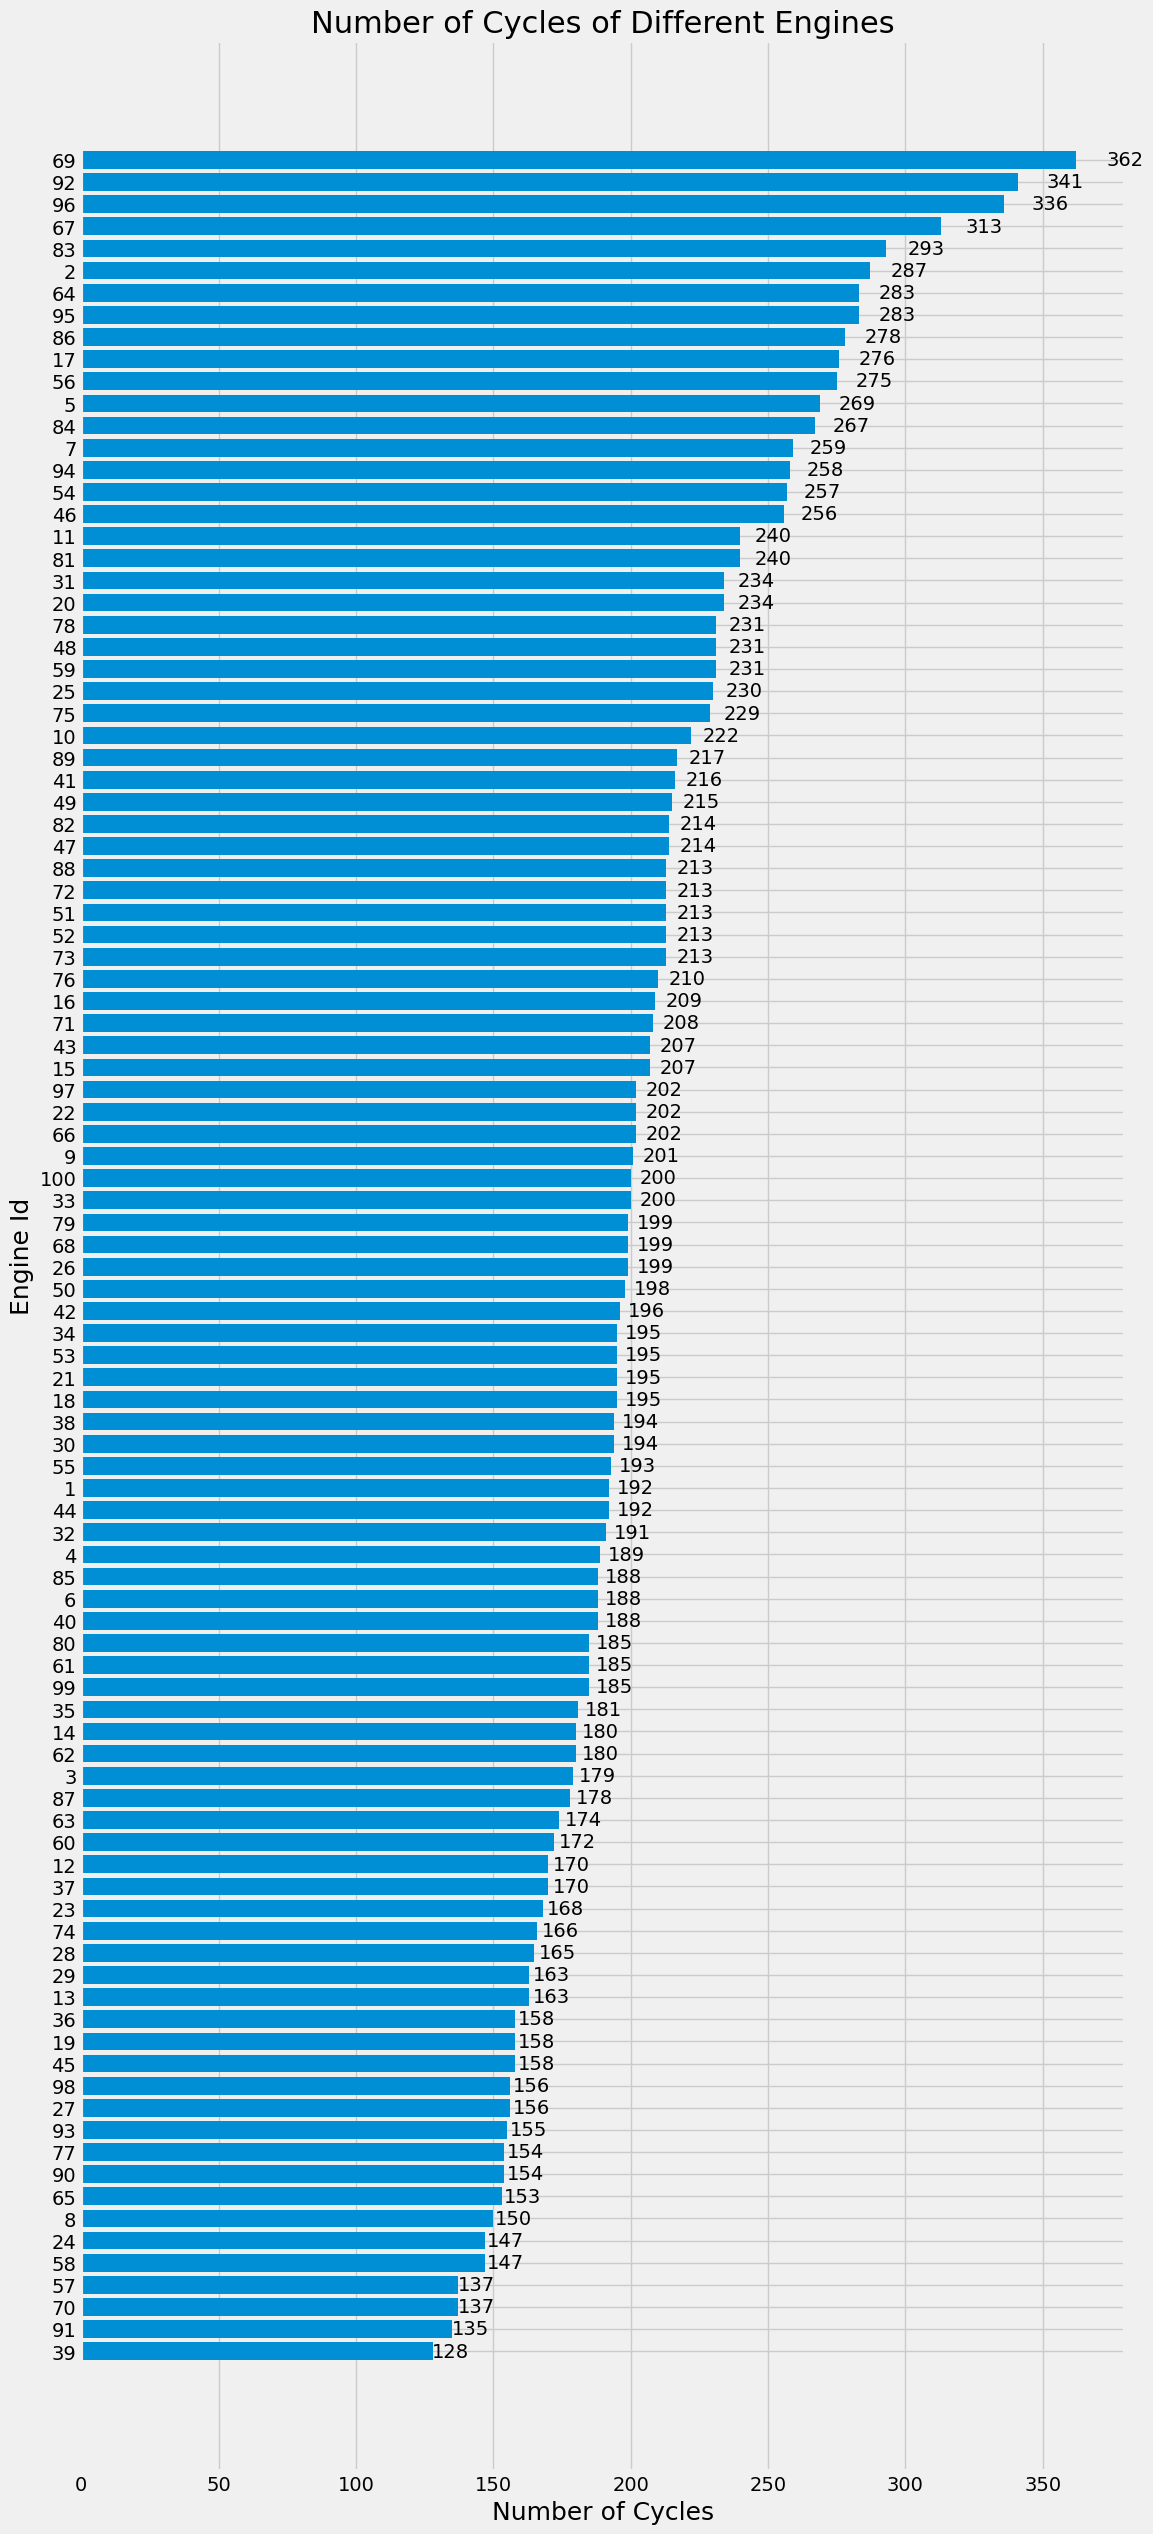

In [6]:
cnt_train=train_data[["ID", "cycles"]].groupby("ID").max().sort_values(by="cycles", ascending=True)
cnt_ind = [str(i) for i in cnt_train.index.to_list()]
cnt_val = list(cnt_train.cycles.values)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(12, 30))
rects = ax.barh(cnt_ind, cnt_val)
ax.set_title("Number of Cycles of Different Engines", fontsize=22)
ax.set_ylabel("Engine Id", fontsize=18)
ax.set_xlabel("Number of Cycles", fontsize=18)
ax.grid(True)

for rect in rects:
    width = rect.get_width()
    plt.text(1.05*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
             '%d' % int(width),
             ha='center', va='center')

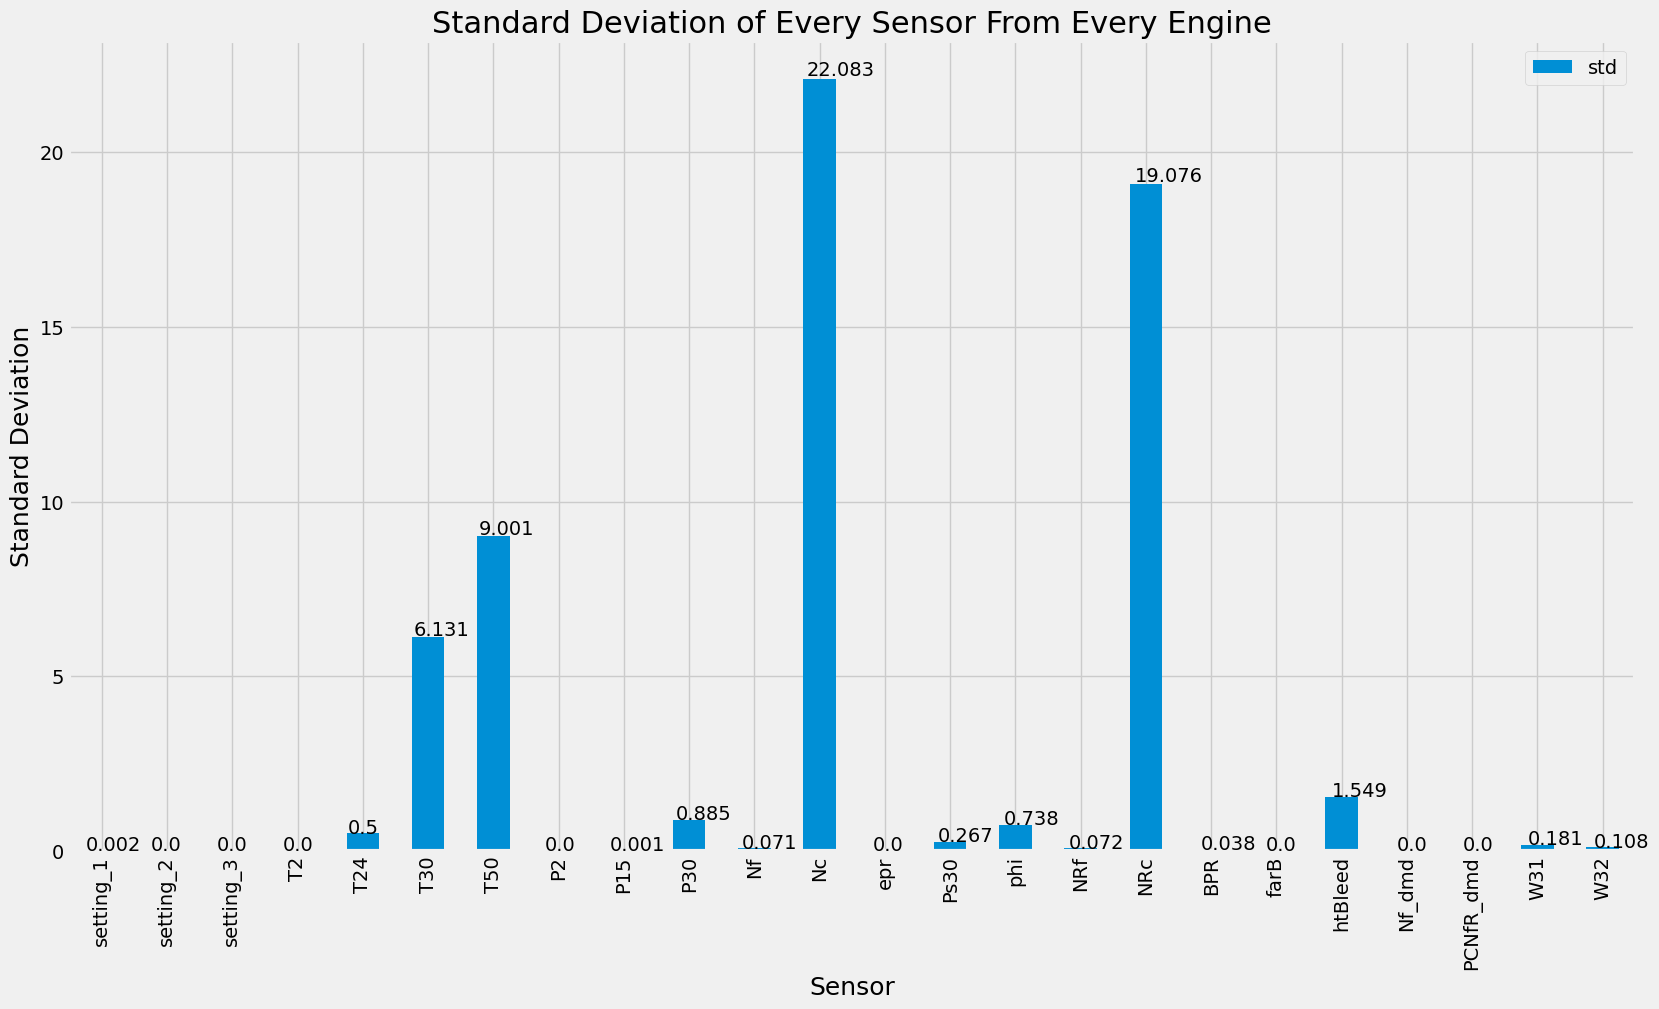

In [7]:
subset_stats = train_data.agg(['mean', 'std']).T[2:]
ax = subset_stats.plot.bar(figsize=(18,10),
                           y="std")
ax.set_title("Standard Deviation of Every Sensor From Every Engine", fontsize=22)
ax.set_xlabel("Sensor", fontsize=18)
ax.set_ylabel("Standard Deviation", fontsize=18)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

In [8]:
#In the context of your dataset, this function can be used to generate target RUL values for training a predictive model. Here’s how it can be integrated:
#Generating RUL for each cycle:
#For each engine (identified by ID), you can generate the RUL array using this function.
#For example, if an engine has 200 cycles, you would call process_targets(200) or process_targets(200, early_rul) to generate the RUL values.

def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [9]:
# The process_input_data_with_targets function is designed to transform time-series data into a 3D array
# of input sequences (and optionally, corresponding target values) for use in machine learning models. This
# type of transformation is common when preparing data for sequence-based models such as Recurrent Neural Networks
# (RNNs) or Long Short-Term Memory (LSTM) networks.

def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
  num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
  num_features = input_data.shape[1]
  output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
  if target_data is None:
      for batch in range(num_batches):
          output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
      return output_data
  else:
      output_targets = np.repeat(np.nan, repeats = num_batches)
      for batch in range(num_batches):
          output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
          output_targets[batch] = target_data[(shift*batch + (window_length-1))]
      return output_data, output_targets

In [10]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
  max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
  if max_num_test_batches < num_test_windows:
      required_len = (max_num_test_batches -1)* shift + window_length
      batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                        target_data = None,
                                                                        window_length = window_length, shift = shift)
      return batched_test_data_for_an_engine, max_num_test_batches
  else:
     required_len = (num_test_windows - 1) * shift + window_length
     batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                       target_data = None,
                                                                      window_length = window_length, shift = shift)
  return batched_test_data_for_an_engine, num_test_windows

In [12]:
test_data = pd.read_csv("./datasets/test_FD001.txt", sep = "\s+", header = None,names=columns )
true_rul = pd.read_csv("./datasets/RUL_FD001.txt", sep = '\s+', header = None)

In [13]:
from sklearn.preprocessing import MinMaxScaler
columns_to_be_dropped =['ID', 'setting_1', 'setting_2', 'setting_3', 'T2', 'P2', 'P15', 'P30', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd']

window_length = 30
shift = 1
early_rul = 125
processed_train_data = []
processed_train_targets = []

In [14]:
# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

In [15]:
train_data_first_column = train_data['ID']
test_data_first_column = test_data['ID']

In [16]:
scaler = MinMaxScaler(feature_range = (-1,1))
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

In [17]:
train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

In [18]:
test_data.head(40)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,-1.000000,0.090361,-0.378679,-0.461175,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.735680,-0.382070,-0.333333,0.116279,0.323667
1,1.0,-0.994460,-0.698795,-0.240898,-0.555368,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.590463,-0.573682,-0.166667,0.364341,0.373654
2,1.0,-0.988920,-0.246988,-0.306736,-0.355503,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.688719,-0.082724,-0.166667,0.457364,0.442695
3,1.0,-0.983380,-0.259036,-0.429693,-0.183997,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.659820,-0.485956,-0.500000,0.333333,0.324220
4,1.0,-0.977839,-0.216867,-0.295836,-0.335922,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.694499,-0.398230,-0.666667,0.317829,0.432753
5,1.0,-0.972299,-0.457831,-0.647700,-0.565159,-0.696970,-0.737683,-0.511905,0.377399,-0.411765,-0.715967,-0.238938,-0.333333,0.193798,0.249655
6,1.0,-0.966759,-0.457831,-0.463702,-0.237340,-0.545455,-0.733824,-0.452381,0.415778,-0.470588,-0.638456,-0.488265,-0.500000,0.100775,0.383596
7,1.0,-0.961219,-0.198795,-0.570525,-0.370695,-0.545455,-0.720632,-0.571429,0.449893,-0.470588,-0.731758,-0.258176,-0.166667,0.410853,0.182546
8,1.0,-0.955679,-0.596386,-0.029867,0.013842,-0.515152,-0.759311,-0.380952,0.424307,-0.500000,-0.646919,-0.150442,-0.500000,0.488372,0.540735
9,1.0,-0.950139,-0.481928,-0.380423,-0.446658,-0.575758,-0.728798,-0.654762,0.411514,-0.470588,-0.647642,-0.350519,-0.500000,0.131783,0.347142


In [19]:
num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

In [20]:
# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

In [21]:
# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

In [22]:
# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


In [23]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 14)
Processed validation data shape:  (3547, 30, 14)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


In [24]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D
from keras.layers import Dropout, Input
from keras import initializers
from keras.layers import MaxPooling1D
from keras.models import Model
from keras.layers import TimeDistributed, Flatten
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

In [25]:
def create_compiled_model(lr=0.001, drop_CNN=0, drop_dense=0.2, kernel_size=3):
    model = Sequential()
    intput_shape=(window_length, processed_train_data.shape[2])
    model.add(Conv1D(128, kernel_size=kernel_size, padding = "same", activation="relu", input_shape = intput_shape))
    model.add(Dropout(drop_CNN))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Conv1D(128,kernel_size=kernel_size, padding = "same", activation="relu"))
    model.add(Dropout(drop_CNN))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units = 128, return_sequences=True))
    model.add(LSTM(units = 128, return_sequences=False))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(drop_dense))
    model.add(Dense(1, activation = 'linear'))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse')

    return model

In [26]:
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 10,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)

c:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
222/222 - 9s - 41ms/step - loss: 1852.4012 - val_loss: 303.4508 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
222/222 - 4s - 20ms/step - loss: 249.1664 - val_loss: 190.1203 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
222/222 - 5s - 22ms/step - loss: 186.2785 - val_loss: 155.5067 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
222/222 - 4s - 19ms/step - loss: 170.7658 - val_loss: 153.9881 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
222/222 - 4s - 19ms/step - loss: 157.4673 - val_loss: 129.0167 - learning_rate: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
222/222 - 4s - 20ms/step - loss: 122.0437 - val_loss: 107.9203 - learning_rate: 1.0000e-04

Epoch 7: LearningRate

In [27]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 128)        │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 8, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │        25,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,031,861 (3.94 MB)

 Trainable params: 343,953 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 687,908 (2.62 MB)

None


In [28]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
RMSE:  13.529850417416139


In [29]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  14.136399062045646


In [31]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  340.809322877317


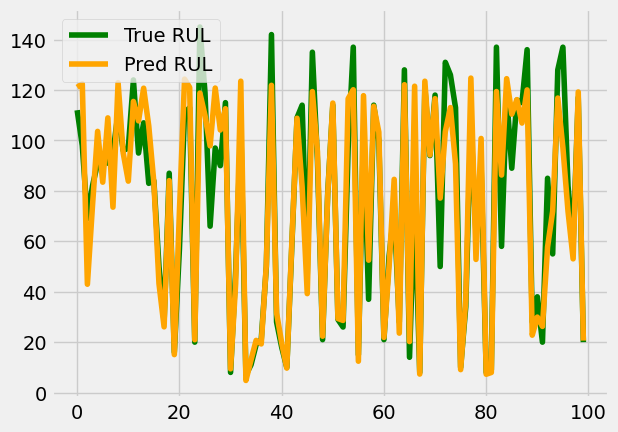

In [32]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "green")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "orange")
plt.legend()
plt.show()

In [33]:
input_sequence = [
    [-1.000000, 0.090361, -0.378679, -0.461175, -0.575758, -0.744773, -0.583333, 0.292111, -0.558824, -0.735680, -0.382070, -0.333333, 0.116279, 0.323667],
    [-0.994460, -0.698795, -0.240898, -0.555368, -0.666667, -0.706632, -0.226190, 0.479744, -0.470588, -0.590463, -0.573682, -0.166667, 0.364341, 0.373654],
    [-0.988920, -0.246988, -0.306736, -0.355503, -0.545455, -0.683837, -0.226190, 0.398721, -0.558824, -0.688719, -0.082724, -0.166667, 0.457364, 0.442695],
    [-0.983380, -0.259036, -0.429693, -0.183997, -0.606061, -0.788567, -0.488095, 0.147122, -0.500000, -0.659820, -0.485956, -0.500000, 0.333333, 0.324220],
    [-0.977839, -0.216867, -0.295836, -0.335922, -0.666667, -0.795208, -0.452381, 0.475480, -0.558824, -0.694499, -0.398230, -0.666667, 0.317829, 0.432753],
    [-0.972299, -0.457831, -0.647700, -0.565159, -0.696970, -0.737683, -0.511905, 0.377399, -0.411765, -0.715967, -0.238938, -0.333333, 0.193798, 0.249655],
    [-0.966759, -0.457831, -0.463702, -0.237340, -0.545455, -0.733824, -0.452381, 0.415778, -0.470588, -0.638456, -0.488265, -0.500000, 0.100775, 0.383596],
    [-0.961219, -0.198795, -0.570525, -0.370695, -0.545455, -0.720632, -0.571429, 0.449893, -0.470588, -0.731758, -0.258176, -0.166667, 0.410853, 0.182546],
    [-0.955679, -0.596386, -0.029867, 0.013842, -0.515152, -0.759311, -0.380952, 0.424307, -0.500000, -0.646919, -0.150442, -0.500000, 0.488372, 0.540735],
    [-0.950139, -0.481928, -0.380423, -0.446658, -0.575758, -0.728798, -0.654762, 0.411514, -0.470588, -0.647642, -0.350519, -0.500000, 0.131783, 0.347142],
    [-0.944598, -0.500000, -0.564421, -0.271438, -0.575758, -0.731311, -0.547619, 0.390192, -0.470588, -0.665187, -0.484417, -0.500000, 0.426357, 0.288870],
    [-0.939058, -0.198795, -0.285372, -0.474342, -0.636364, -0.746119, -0.500000, 0.415778, -0.470588, -0.665703, -0.434398, -0.500000, 0.503876, 0.354046],
    [-0.933518, -0.560241, -0.212993, -0.267725, -0.636364, -0.785157, -0.404762, 0.569296, -0.558824, -0.678192, -0.294344, -0.333333, 0.457364, 0.307650],
    [-0.927978, -0.385542, -0.471550, -0.303511, -0.606061, -0.788477, -0.535714, 0.390192, -0.470588, -0.686655, -0.196614, -0.333333, 0.379845, 0.554819],
    [-0.922438, -0.222892, -0.399608, -0.441594, -0.696970, -0.723055, -0.404762, 0.147122, -0.647059, -0.652389, -0.296653, -0.333333, 0.395349, 0.306269],
    [-0.916898, -0.331325, -0.412688, -0.138758, -0.393939, -0.818631, -0.357143, 0.479744, -0.352941, -0.650222, -0.191227, -0.666667, 0.131783, 0.254350],
    [-0.911357, -0.409639, -0.491607, -0.261648, -0.515152, -0.783541, -0.500000, 0.449893, -0.588235, -0.722985, 0.021932, -0.500000, 0.472868, 0.233637],
    [-0.905817, -0.168675, -0.324613, -0.276165, -0.575758, -0.763170, -0.297619, 0.471215, -0.470588, -0.656518, -0.173528, -0.500000, 0.271318, 0.529688],
    [-0.900277, -0.265060, -0.366034, -0.323093, -0.666667, -0.774118, -0.523810, 0.437100, -0.617647, -0.696873, -0.505194, -0.500000, 0.426357, 0.344104],
    [-0.894737, -0.156627, -0.270111, -0.377110, -0.545455, -0.825989, -0.273810, 0.530917, -0.500000, -0.704304, -0.345902, -0.333333, 0.333333, 0.210439],
    [-0.889197, -0.102410, -0.465446, -0.427752, -0.545455, -0.712824, -0.392857, 0.432836, -0.323529, -0.722159, -0.288188, -0.333333, 0.271318, 0.403756],
    [-0.883657, -0.253012, -0.488119, -0.263673, -0.696970, -0.778157, -0.511905, 0.159915, -0.529412, -0.701208, 0.006541, -0.333333, 0.240310, 0.333333],
    [-0.878116, -0.451807, -0.281884, -0.566509, -0.575758, -0.727811, -0.595238, 0.411514, -0.470588, -0.679740, -0.332820, -0.166667, 0.488372, 0.172052],
    [-0.872576, -0.331325, 0.013734, -0.395679, -0.484848, -0.806246, -0.476190, 0.437100, -0.294118, -0.682527, -0.365140, -0.166667, 0.240310, 0.388843],
    [-0.867036, -0.373494, -0.503379, -0.392978, -0.363636, -0.801938, -0.380952, 0.522388, -0.411765, -0.703685, -0.416699, -0.166667, 0.271318, 0.337476],
    [-0.861496, -0.234940, -0.466318, -0.128292, -0.454545, -0.715516, -0.428571, 0.390192, -0.441176, -0.698834, -0.461331, -0.500000, -0.023256, 0.274510],
    [-0.855956, -0.475904, -0.319381, -0.390277, -0.424242, -0.781298, -0.416667, 0.334755, -0.588235, -0.718237, -0.041939, -0.333333, 0.131783, 0.377796],
    [-0.850416, -0.566265, 0.011990, -0.357191, -0.484848, -0.696401, -0.761905, 0.343284, -0.441176, -0.639282, -0.060408, -0.333333, 0.069767, 0.259321],
    [-0.844875, -0.554217, -0.297580, -0.464551, -0.454545, -0.781208, -0.321429, 0.577825, -0.441176, -0.657447, -0.258946, -0.333333, 0.364341, 0.292184],
    [-0.839335, -0.048193, -0.359930, -0.367995, -0.424242, -0.769182, -0.345238, 0.317697, -0.352941, -0.640314, -0.337437, -0.500000, 0.472868, 0.415907]
]


In [34]:
input_sequence = np.array(input_sequence).astype(np.float32)  # Convert to float32

input_sequence = input_sequence[:, :]

# Reshape the input sequence to match the expected input shape of the model
input_data = input_sequence.reshape(1, 30, 14)

# Use the model to make a prediction
prediction = model.predict(input_data)

# Print the prediction
print(f"The predicted RUL value is: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
The predicted RUL value is: [[122.10687]]


In [35]:
import joblib

joblib.dump(model, 'model.pkl')

['model.pkl']